In [ ]:
import time
import numpy as np

import tensorflow as tf

from tensorflow.python.framework import function

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/your_datafile_folder", one_hot=True)

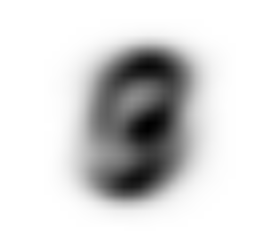

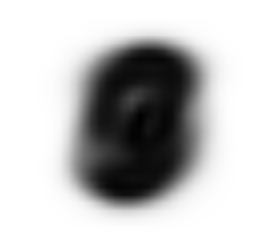

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def show(digit_vector):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """

    images = np.array(digit_vector).reshape((28, 28))

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    imgplot = ax.imshow(images, cmap=mpl.cm.Greys)
    # imgplot.set_interpolation('nearest')
    # ax.xaxis.set_ticks_position('top')
    # ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    plt.grid('off')
    plt.show()
    
# img, label = mnist_data.train.next_batch(1)
# show(img)

# print(img)


xbatch, ybatch = mnist.train.next_batch(mnist.train.num_examples)
xmean = xbatch.mean(axis=0).astype('float64')
xvar = np.clip(xbatch.var(axis=0), 1e-7, np.inf).astype('float64')

show(xmean)
show(xvar)

In [277]:
'''GAN'''

dim_input = 28 * 28
dim_hidden = 64
batch_size = 500
learning_rate = 1e-4
max_iter = 10000

alpha = 0


def gan(batch_size, learning_rate, max_iter):
    g = tf.Graph()
    dtype = tf.float32
    
    with g.as_default():
        x = tf.placeholder(dtype, [None, dim_input])
        
        with tf.name_scope('generator'):
            wgen = tf.Variable(tf.random_normal([dim_hidden, dim_input], stddev=1.0 / tf.sqrt(float(dim_input)), dtype=dtype),
                                       name='gen_w')
            bgen = tf.Variable(tf.constant(xmean, dtype=dtype), name='gen_b')
            
            hepsilon = tf.random_normal(shape=[batch_size, dim_hidden], dtype=dtype)
            xout = tf.matmul(hepsilon, wgen) * xvar + bgen
            
        with tf.name_scope('discriminator'):
            wdis1 = tf.Variable(tf.random_normal([dim_input, dim_hidden], stddev=1.0 / tf.sqrt(float(dim_input)), dtype=dtype),
                                       name='dis_w1')
            bdis1 = tf.Variable(tf.random_normal([dim_hidden]), dtype=dtype, name='dis_b1')
            
            wdis2 = tf.Variable(tf.random_normal([dim_hidden, 1], dtype=dtype),
                                       name='dis_w2')
            bdis2 = tf.Variable(tf.random_normal([1]), dtype=dtype, name='dis_b2')
            
            
            yx = tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(x, wdis1) + bdis1), wdis2) + bdis2)
            yxout = tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(xout, wdis1) + bdis1), wdis2) + bdis2)
            
        t_vars = tf.trainable_variables()

        dis_vars = [var for var in t_vars if 'dis_' in var.name]
        gen_vars = [var for var in t_vars if 'gen_' in var.name]
        
        dis_loss_real = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(yx, tf.ones_like(yx)))
        dis_loss_fake = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(yxout, tf.zeros_like(yxout)))
        dis_loss = dis_loss_real + dis_loss_fake
        gen_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(yxout, tf.ones_like(yxout)))

        # loss = tf.reduce_mean(gx - tf.exp(gy))
        dis_optimizer = tf.train.AdamOptimizer(learning_rate)
        gen_optimizer = tf.train.AdamOptimizer(2 * learning_rate)
        
        # optimizer = tf.train.RMSPropOptimizer(learning_rate)
        # optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        dis_train_op = dis_optimizer.minimize(dis_loss, var_list=dis_vars)
        gen_train_op = gen_optimizer.minimize(gen_loss, var_list=gen_vars)
        
        sess = tf.Session(graph=g)
        sess.run(tf.initialize_all_variables())
        
        train_err = []
        for i in xrange(max_iter):
            xbatch, ybatch = mnist.train.next_batch(batch_size)
            _, _, loss_value = sess.run([dis_train_op, gen_train_op, dis_loss], feed_dict={x: xbatch})
            
            if i % 100 == 0:
                print('Num iteration: %d Loss: %0.04f' %(i, loss_value / batch_size))
                
                train_err.append(loss_value / batch_size)
                
        node_list = {'xout': xout, 'yx': yx, 'yxout': yxout,
                     'wgen': wgen, 'bgen': bgen,
                     'wdis1': wdis1, 'bdis1': bdis1,
                     'wdis2': wdis2, 'bdis': bdis2,
                    }
        para_list = {'wgen': sess.run(wgen), 'bgen': sess.run(bgen),
                     'wdis1': sess.run(wdis1), 'bdis1': sess.run(bdis1),
                     'wdis2': sess.run(wdis2), 'bdis2': sess.run(bdis2),
                    }
            
    return g, node_list, para_list, train_err


g, node_list, para_list, train_err = gan(batch_size, learning_rate, max_iter)

            

Num iteration: 0 Loss: 1.2443
Num iteration: 100 Loss: 1.2017
Num iteration: 200 Loss: 1.1688
Num iteration: 300 Loss: 1.1429
Num iteration: 400 Loss: 1.0690
Num iteration: 500 Loss: 0.9251
Num iteration: 600 Loss: 0.7884
Num iteration: 700 Loss: 0.7774
Num iteration: 800 Loss: 0.7488
Num iteration: 900 Loss: 0.7585
Num iteration: 1000 Loss: 0.7682
Num iteration: 1100 Loss: 0.7798
Num iteration: 1200 Loss: 0.7757
Num iteration: 1300 Loss: 0.7931
Num iteration: 1400 Loss: 0.8037
Num iteration: 1500 Loss: 0.8134
Num iteration: 1600 Loss: 0.7996
Num iteration: 1700 Loss: 0.8070
Num iteration: 1800 Loss: 0.8127
Num iteration: 1900 Loss: 0.8164
Num iteration: 2000 Loss: 0.8136
Num iteration: 2100 Loss: 0.9776
Num iteration: 2200 Loss: 0.9936
Num iteration: 2300 Loss: 0.8993
Num iteration: 2400 Loss: 0.8417
Num iteration: 2500 Loss: 0.8719
Num iteration: 2600 Loss: 1.0543
Num iteration: 2700 Loss: 0.9714
Num iteration: 2800 Loss: 0.8370
Num iteration: 2900 Loss: 0.8831
Num iteration: 3000 Lo

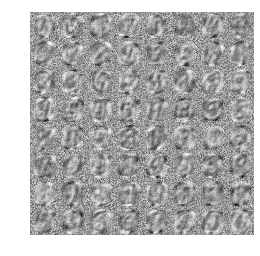

In [278]:
nrow = 8;

# check the learned template

U = para_list['wgen']
# print U[1].reshape(28, 28).shape
  
template = np.vstack([np.hstack([U[j].reshape((28, 28))
                                 for j in range(i*nrow, i*nrow+nrow)]) for i in range(int(dim_hidden / nrow))])

plt.imshow(template, cmap=mpl.cm.Greys)
plt.axis('off')
plt.grid('off')
plt.show()

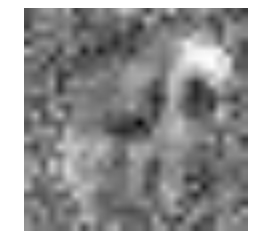

In [283]:
sess = tf.Session()

U = para_list['wgen']
xnoise =  tf.random_normal(shape=[1, dim_hidden], dtype=tf.float32)
xtemp = np.dot(sess.run(xnoise), U) + para_list['bgen']

show(xtemp)

In [ ]:
'''auto GAN-coder'''

dim_input = 28 * 28
dim_hidden = 64
batch_size = 200
learning_rate = 1e-4

max_iter = 50000

def auto_gan_coder(batch_size, learning_rate, max_iter):
    g = tf.Graph()
    dtype = tf.float32
    
    with g.as_default():
        x = tf.placeholder(dtype, [None, dim_input])

        
        # encoding function
        with tf.name_scope('gen_encode'):
            wencode = tf.Variable(tf.random_normal([dim_input, dim_hidden], stddev=1.0 / tf.sqrt(float(dim_input)), dtype=dtype),
                                       name='gen_wencode')
            bencode = tf.Variable(tf.random_normal([dim_hidden]), dtype=dtype, name='gen_bencode')

            # htemp = tf.matmul(tf.div(x - xmean, xvar), wencode) + bencode
            htemp = tf.matmul(x, wencode) + bencode
            # stochastic
            # hepsilon = tf.random_uniform(shape=tf.shape(htemp), dtype=dtype)
            # determinastic
            # hepsilon = tf.ones(shape=tf.shape(htemp), dtype=dtype) * 0.5
            hout = tf.nn.relu(htemp)
            # hout = tf.nn.relu(htemp - hepsilon)
            
        with tf.name_scope('gen_decode'):
            wdecode = tf.Variable(tf.random_normal([dim_hidden, dim_input], stddev=1.0 / tf.sqrt(float(dim_hidden)), dtype=dtype), 
                                  name='gen_wdecode')
            
            # scale_para = tf.Variable(tf.constant(xvar, dtype=dtype), name="gen_scale_para")
            # shift_para = tf.Variable(tf.constant(xmean, dtype=dtype), name="gen_shift_para")
            # ytemp = tf.sigmoid(tf.matmul(hout, wdecode))
            ytemp = tf.nn.tanh(tf.matmul(hout, wdecode))
            # xepsilon = tf.random_normal(shape=tf.shape(ytemp), stddev=1.0/tf.sqrt(float(dim_input)), dtype=dtype)
            # yout = ytemp * tf.abs(scale_para) + shift_para
            yout = ytemp * xvar + xmean
            
        with tf.name_scope('discriminator'):
            w1 = tf.Variable(tf.random_normal([dim_input, dim_hidden], stddev=1.0 / tf.sqrt(float(dim_input)), dtype=dtype),
                                       name='dis_w1')
            b1 = tf.Variable(tf.random_normal([dim_hidden]), dtype=dtype, name='dis_b1')
            
            w2 = tf.Variable(tf.random_normal([dim_hidden, dim_hidden], stddev=1.0 / tf.sqrt(float(dim_input)), dtype=dtype),
                                       name='dis_w2')
            b2 = tf.Variable(tf.random_normal([dim_hidden]), dtype=dtype, name='dis_b2')
            
            
            gx = (tf.matmul(tf.nn.relu(tf.matmul(x, w1) + b1), w2) + b2)
            gy = (tf.matmul(tf.nn.relu(tf.matmul(yout, w1) + b1), w2) + b2)
        
        t_vars = tf.trainable_variables()

        dis_vars = [var for var in t_vars if 'dis_' in var.name]
        gen_vars = [var for var in t_vars if 'gen_' in var.name]

        dis_loss_real = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(gx, tf.ones_like(gx)))
        dis_loss_fake = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(gy, tf.zeros_like(gy)))
        dis_loss = dis_loss_real + dis_loss_fake
        gen_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(gy, tf.ones_like(gy)))

        # loss = tf.reduce_mean(gx - tf.exp(gy))
        dis_optimizer = tf.train.AdamOptimizer(learning_rate)
        gen_optimizer = tf.train.AdamOptimizer(2 * learning_rate)
        
        # optimizer = tf.train.RMSPropOptimizer(learning_rate)
        # optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        dis_train_op = dis_optimizer.minimize(dis_loss, var_list=dis_vars)
        gen_train_op = gen_optimizer.minimize(gen_loss, var_list=gen_vars)
        
        sess = tf.Session(graph=g)
        sess.run(tf.initialize_all_variables())
        
        train_err = []
        for i in xrange(max_iter):
            xbatch, ybatch = mnist.train.next_batch(batch_size)
            _, _, dis_loss_value = sess.run([dis_train_op, gen_train_op, dis_loss], feed_dict={x: xbatch})
            
            if i % 100 == 0:
                print('Num iteration: %d Loss: %0.04f' %(i, dis_loss_value / batch_size))
                learning_rate = 0.8 * learning_rate
                train_err.append(dis_loss_value / batch_size)
        
        node_list = {'hout': hout, 'yout': yout, 'gx': gx,
                     'wencode': wencode, 'bencode': bencode,
                     'wdecode': wdecode, 
                     'w1': w1, 'w2' : w2,
                     'b1': b1, 'b2': b2,
                    }
        para_list = {'wencode': sess.run(wencode), 'bencode': sess.run(bencode),
                     'wdecode': sess.run(wdecode), 
                     'w1': sess.run(w1), 'w2' : sess.run(w2),
                     'b1': sess.run(b1), 'b2': sess.run(b2),
                    }
            
    return g, node_list, para_list, train_err


g, node_list, para_list, train_err = auto_gan_coder(batch_size, learning_rate, max_iter)


Num iteration: 0 Loss: 102.5733
Num iteration: 100 Loss: 94.2428
Num iteration: 200 Loss: 86.2510
Num iteration: 300 Loss: 81.5147
Num iteration: 400 Loss: 76.6653
Num iteration: 500 Loss: 70.7847
Num iteration: 600 Loss: 65.8916
Num iteration: 700 Loss: 63.6887
Num iteration: 800 Loss: 54.9682
Num iteration: 900 Loss: 46.1496
Num iteration: 1000 Loss: 45.5268
Num iteration: 1100 Loss: 41.6852
Num iteration: 1200 Loss: 38.3132
Num iteration: 1300 Loss: 33.4284
Num iteration: 1400 Loss: 27.9581
Num iteration: 1500 Loss: 29.8579
Num iteration: 1600 Loss: 27.7414
Num iteration: 1700 Loss: 25.4733
Num iteration: 1800 Loss: 22.5550
Num iteration: 1900 Loss: 20.3362
Num iteration: 2000 Loss: 19.7038
Num iteration: 2100 Loss: 17.1421
Num iteration: 2200 Loss: 14.4941
Num iteration: 2300 Loss: 12.9027
Num iteration: 2400 Loss: 9.4206
Num iteration: 2500 Loss: 7.5648
Num iteration: 2600 Loss: 10.1542
Num iteration: 2700 Loss: 15.2439
Num iteration: 2800 Loss: 13.0863
Num iteration: 2900 Loss: 1

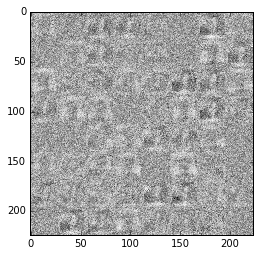

In [393]:
nrow = 8;

# check the learned template

U = para_list['wdecode']
# print U[1].reshape(28, 28).shape
  
template = np.vstack([np.hstack([U[j].reshape((28, 28))
                                 for j in range(i*nrow, i*nrow+nrow)]) for i in range(int(dim_hidden / nrow))])

plt.imshow(template, cmap=mpl.cm.Greys)
# plt.axis('off')
# plt.grid('off')
plt.show()


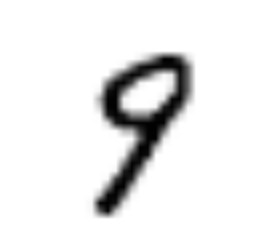

[[   0.            0.           92.65627818   80.34963553    5.49640904
     2.6106148    71.19483238    0.            3.56319001    0.
    78.14499135   12.65747545    0.            0.            0.
    84.97961488    0.            0.           43.35657167    0.            0.
   114.15342473  111.5115367     0.          101.7820178     0.            0.
     0.            0.31157618    0.           96.44963939    0.
     2.44155061    0.           19.81190306    0.           63.06435588
    84.44273622    0.            0.            0.            2.25227752
     0.            0.            0.            0.           25.12616777
     1.23202202    0.           29.78131129    0.            0.
    89.1704791   110.88237167    0.           47.99869234    0.
    97.71990614   28.03660235    0.           65.14756728   35.24714382
     0.            0.        ]]


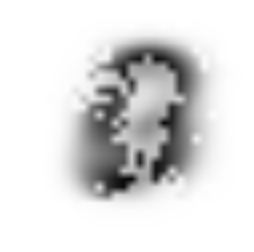

In [394]:

x = mnist.train.next_batch(1)
show(x[0])

wencode = para_list['wencode']
bencode = para_list['bencode']

wdecode = para_list['wdecode']

# htemp = 1.0 / (1 + np.exp(np.dot((x[0] - xmean) / xvar, wencode) + bencode))
htemp = np.maximum(np.dot((x[0] - xmean) / xvar, wencode) + bencode, 0)
xtemp = np.tanh(np.dot(htemp, U)) * xvar + xmean

print htemp

show(xtemp)